## Inspect variables 
Goal:\
Find out what variables matter in predicting catch location

In [4]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parents[1]))

from utilities import get_region_border
from fetch_data import fetch_data_from_fiskeridirektoratet
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from datetime import datetime
import numpy as np
import copernicusmarine

In [5]:
start_year = 2011
end_year = 2024
target_species = "MAC"
search_col = "Hovedart FAO (kode)"

PATH = "/home/peder/data/fiskeridirektoratet/"

info_cols = [
    "Starttidspunkt", "Stopptidspunkt", "Hovedart FAO (kode)",  
    "Sildebestand (kode)", "Rundvekt", "Startposisjon bredde", 
    "Startposisjon lengde", "Stopposisjon bredde", "Stopposisjon lengde"
]
df = pd.DataFrame()

for year in range(start_year, end_year + 1):
    # Construct the URL for the dataset
    data_url = PATH + "elektronisk-rapportering-ers-" + str(year) + \
                "/elektronisk-rapportering-ers-" + str(year) + "-fangstmelding-dca.csv"
    data = pd.read_csv(data_url, delimiter=";", on_bad_lines="skip", skip_blank_lines=True, low_memory=False, na_values='na', parse_dates=True)

    # Remove columns that are not of interest
    data.drop(data.columns.difference(info_cols), axis=1, inplace=True)

    # Filter the data based on the target species
    data = data[data[search_col].str.contains(target_species, na=False)]
    
    df = pd.concat([df, data], ignore_index=True)
    print(f"Year {year} data fetched and filtered.")


Year 2011 data fetched and filtered.
Year 2012 data fetched and filtered.
Year 2013 data fetched and filtered.
Year 2014 data fetched and filtered.
Year 2015 data fetched and filtered.
Year 2016 data fetched and filtered.
Year 2017 data fetched and filtered.
Year 2018 data fetched and filtered.
Year 2019 data fetched and filtered.
Year 2020 data fetched and filtered.
Year 2021 data fetched and filtered.
Year 2022 data fetched and filtered.
Year 2023 data fetched and filtered.
Year 2024 data fetched and filtered.


In [6]:
df.reset_index(drop=True, inplace=True)
mac = df.copy()

# TODO: convert theese columns to float (also replace commas with dots)
pos = ["Startposisjon bredde", "Startposisjon lengde", "Stopposisjon bredde", "Stopposisjon lengde"]
for col in pos:
    mac[col] = mac[col].astype(str).str.replace(",", ".")
    mac[col] = mac[col].astype(float)

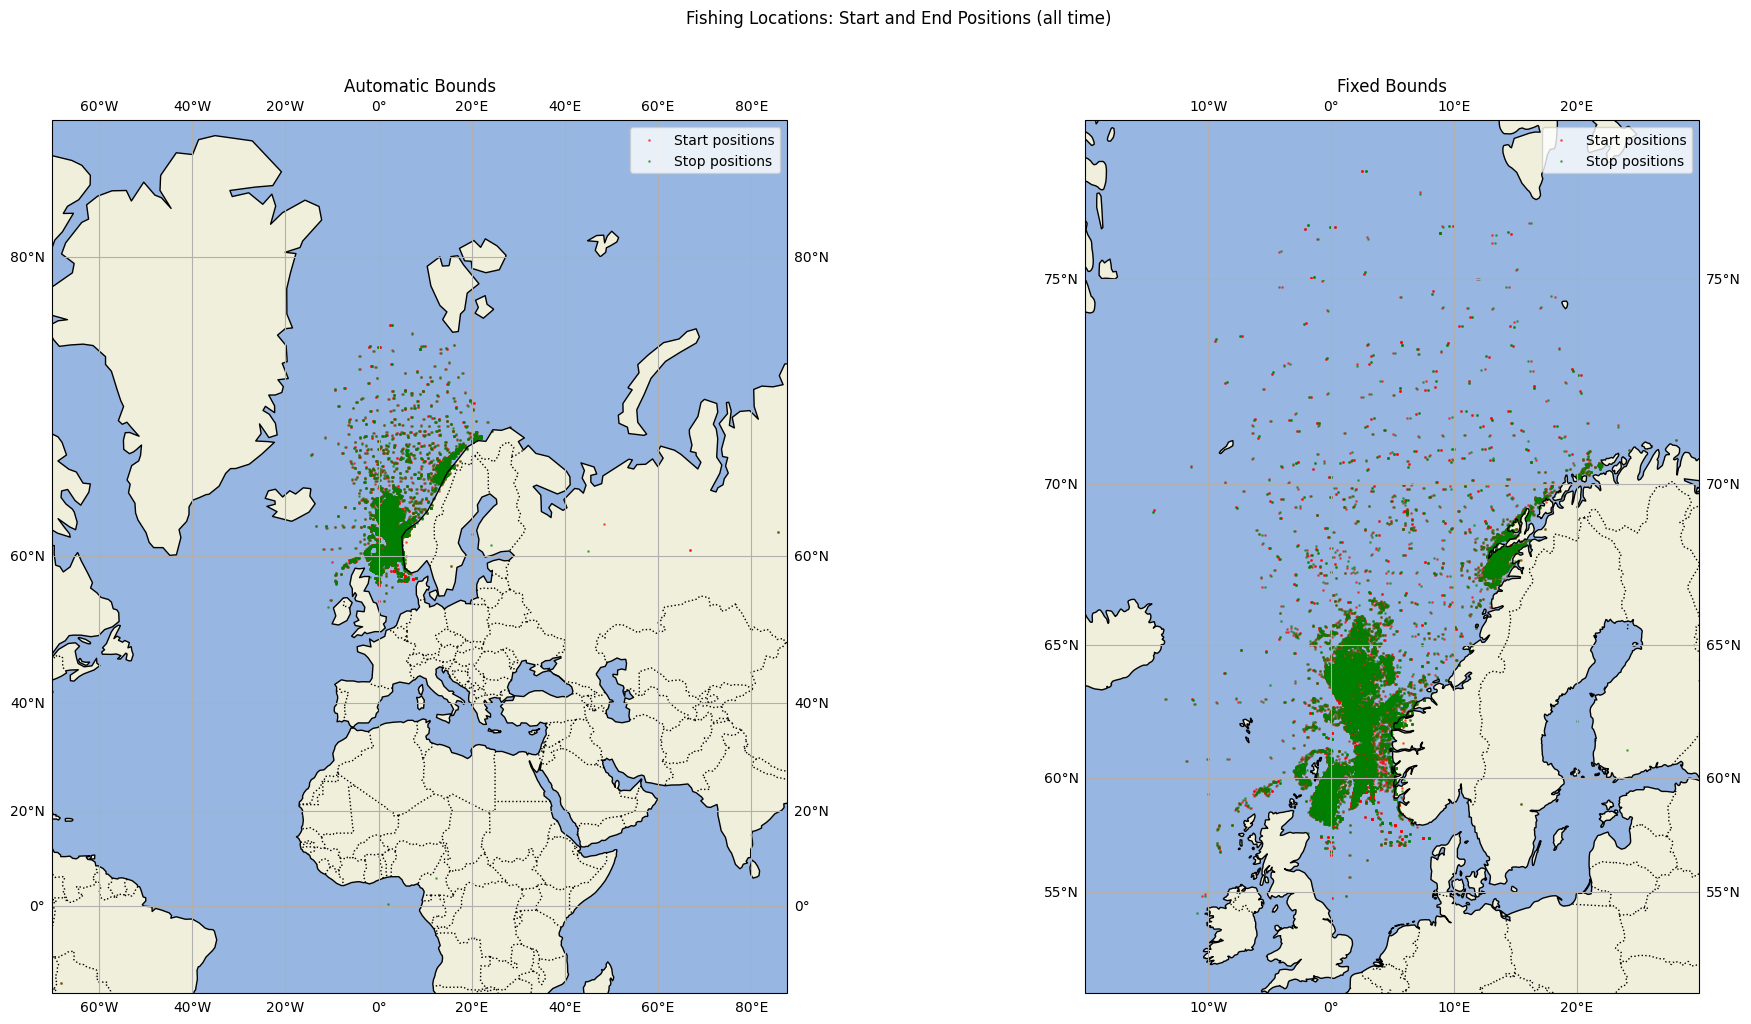

In [7]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': ccrs.Mercator()})

# First subplot (automatic bounds)
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')

ax1.scatter(mac['Startposisjon lengde'], mac['Startposisjon bredde'],
           color='red', s=1, alpha=0.5, transform=ccrs.PlateCarree(),
           label='Start positions')

ax1.scatter(mac['Stopposisjon lengde'], mac['Stopposisjon bredde'],
           color='green', s=1, alpha=0.5, transform=ccrs.PlateCarree(),
           label='Stop positions')

bounds_auto = [
    mac[['Startposisjon lengde', 'Stopposisjon lengde']].min().min() - 2,
    mac[['Startposisjon lengde', 'Stopposisjon lengde']].max().max() + 2,
    mac[['Startposisjon bredde', 'Stopposisjon bredde']].min().min() - 2,
    mac[['Startposisjon bredde', 'Stopposisjon bredde']].max().max() + 2
]
ax1.set_extent(bounds_auto, crs=ccrs.PlateCarree())
ax1.gridlines(draw_labels=True)
ax1.set_title('Automatic Bounds')
ax1.legend()

# Second subplot (fixed bounds)
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')

ax2.scatter(mac['Startposisjon lengde'], mac['Startposisjon bredde'],
           color='red', s=1, alpha=0.5, transform=ccrs.PlateCarree(),
           label='Start positions')

ax2.scatter(mac['Stopposisjon lengde'], mac['Stopposisjon bredde'],
           color='green', s=1, alpha=0.5, transform=ccrs.PlateCarree(),
           label='Stop positions')

bounds_fixed = [-20, 30, 50, 78]
ax2.set_extent(bounds_fixed, crs=ccrs.PlateCarree())
ax2.gridlines(draw_labels=True)
ax2.set_title('Fixed Bounds')
ax2.legend()

plt.suptitle('Fishing Locations: Start and End Positions (all time)', y=1.02)
plt.tight_layout()
plt.show()


In [8]:
# Filter points within fixed bounds
mac_filtered = mac[
    (mac['Startposisjon lengde'].between(-20, 30)) & 
    (mac['Stopposisjon lengde'].between(-20, 30)) &
    (mac['Startposisjon bredde'].between(50, 78)) & 
    (mac['Stopposisjon bredde'].between(50, 78))
].copy()

print(f"Original data points: {len(mac)}")
print(f"Filtered data points: {len(mac_filtered)}")
print(f"Removed points: {len(mac) - len(mac_filtered)} ({((len(mac) - len(mac_filtered))/len(mac)*100):.1f}%)")


Original data points: 26595
Filtered data points: 26584
Removed points: 11 (0.0%)


In [9]:

# TODO: get distance from start to stop position in km
def haversine(lon1, lat1, lon2, lat2):
    from math import radians, sin, cos, sqrt, atan2
    R = 6371.0  # Radius of the Earth in km

    dlon = radians(lon2 - lon1)
    dlat = radians(lat2 - lat1)

    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

# Calculate latitude and longitude distances in km
mac_filtered['lat_distance'] = mac_filtered.apply(lambda row: haversine(
    row['Startposisjon lengde'], 
    row['Startposisjon bredde'], 
    row['Startposisjon lengde'], 
    row['Stopposisjon bredde']
), axis=1)

mac_filtered['lon_distance'] = mac_filtered.apply(lambda row: haversine(
    row['Startposisjon lengde'], 
    row['Startposisjon bredde'], 
    row['Stopposisjon lengde'], 
    row['Startposisjon bredde']
), axis=1)

# Calculate total distance
mac_filtered['distance'] = mac_filtered.apply(lambda row: haversine(
    row['Startposisjon lengde'], 
    row['Startposisjon bredde'], 
    row['Stopposisjon lengde'], 
    row['Stopposisjon bredde']
), axis=1)

# Print statistics
print("Latitude distance (km):")
print(f"Max: {mac_filtered['lat_distance'].max():.2f}")
print(f"Min: {mac_filtered['lat_distance'].min():.2f}")
print(f"Mean: {mac_filtered['lat_distance'].mean():.2f}")
print(f"Median: {mac_filtered['lat_distance'].median():.2f}\n")

print("Longitude distance (km):")
print(f"Max: {mac_filtered['lon_distance'].max():.2f}")
print(f"Min: {mac_filtered['lon_distance'].min():.2f}")
print(f"Mean: {mac_filtered['lon_distance'].mean():.2f}")
print(f"Median: {mac_filtered['lon_distance'].median():.2f}")



Latitude distance (km):
Max: 1212.02
Min: 0.00
Mean: 6.43
Median: 1.78

Longitude distance (km):
Max: 1143.14
Min: 0.00
Mean: 5.29
Median: 0.98


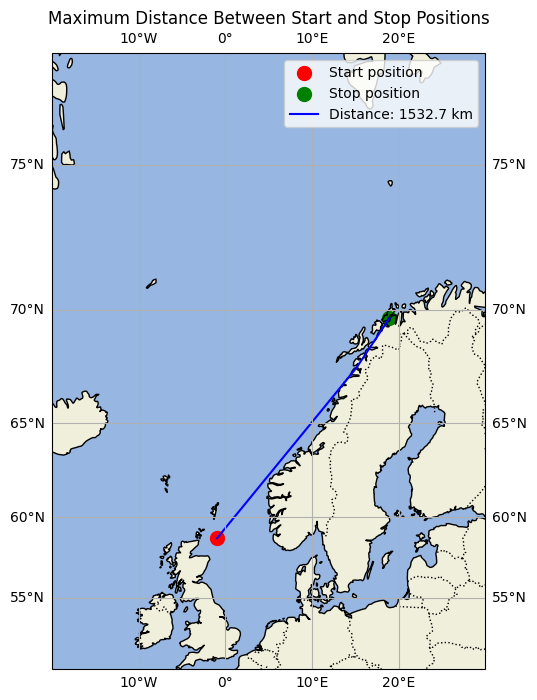

Maximum distance: 1532.7 km
Start position: (58.767°N, -0.950°E)
Stop position: (69.667°N, 18.950°E)
Date: 09.10.2019 17:54:00 to 09.10.2019 20:10:00
Time taken: 2.3 hours
Average speed: 676.2 km/h


In [10]:
# Find the row with maximum distance
max_distance_row = mac_filtered.loc[mac_filtered['distance'].idxmax()]

# Create a figure with Mercator projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.Mercator()})

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the start and end points
ax.scatter(max_distance_row['Startposisjon lengde'], max_distance_row['Startposisjon bredde'],
          color='red', s=100, transform=ccrs.PlateCarree(), label='Start position')
ax.scatter(max_distance_row['Stopposisjon lengde'], max_distance_row['Stopposisjon bredde'],
          color='green', s=100, transform=ccrs.PlateCarree(), label='Stop position')

# Draw a line between start and end points
plt.plot([max_distance_row['Startposisjon lengde'], max_distance_row['Stopposisjon lengde']],
         [max_distance_row['Startposisjon bredde'], max_distance_row['Stopposisjon bredde']],
         color='blue', transform=ccrs.PlateCarree(), label=f'Distance: {max_distance_row["distance"]:.1f} km')

# Set extent to match the fixed bounds we used earlier
ax.set_extent(bounds_fixed, crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
ax.set_title('Maximum Distance Between Start and Stop Positions')
ax.legend()

plt.show()

# Print details
print(f"Maximum distance: {max_distance_row['distance']:.1f} km")
print(f"Start position: ({max_distance_row['Startposisjon bredde']:.3f}°N, {max_distance_row['Startposisjon lengde']:.3f}°E)")
print(f"Stop position: ({max_distance_row['Stopposisjon bredde']:.3f}°N, {max_distance_row['Stopposisjon lengde']:.3f}°E)")
print(f"Date: {max_distance_row['Starttidspunkt']} to {max_distance_row['Stopptidspunkt']}")
# Convert timestamps to datetime objects
start_time = pd.to_datetime(max_distance_row['Starttidspunkt'], format='%d.%m.%Y %H:%M:%S')
stop_time = pd.to_datetime(max_distance_row['Stopptidspunkt'], format='%d.%m.%Y %H:%M:%S')

# Calculate time difference in hours
time_diff = (stop_time - start_time).total_seconds() / 3600

# Calculate speed in km/h
speed = max_distance_row['distance'] / time_diff

print(f"Time taken: {time_diff:.1f} hours")
print(f"Average speed: {speed:.1f} km/h")

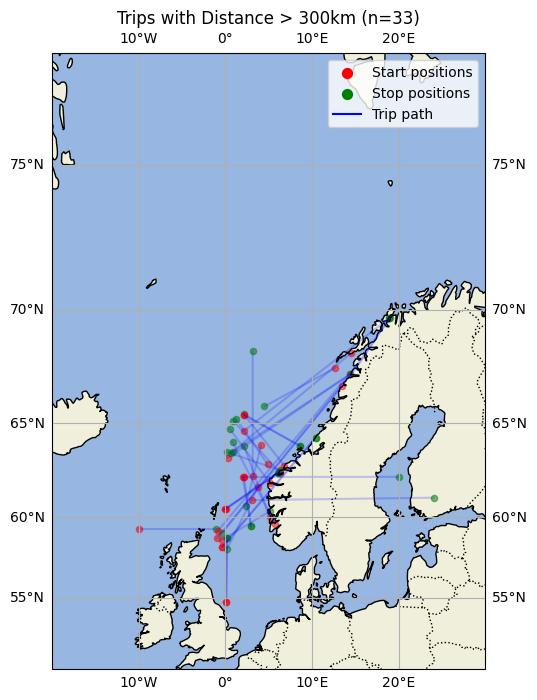

Number of trips > 300km: 33
Average distance: 611.7 km
Maximum distance: 1532.7 km
Minimum distance: 310.7 km
Average speed: 260.4 km/h
Maximum speed: 892.8 km/h
Minimum speed: 49.1 km/h


In [ ]:
# Filter for distances greater than 300km
long_trips = mac_filtered[mac_filtered['distance'] > 300].copy()

# Convert timestamps to datetime for all trips
long_trips['start_time'] = pd.to_datetime(long_trips['Starttidspunkt'], format='%d.%m.%Y %H:%M:%S')
long_trips['stop_time'] = pd.to_datetime(long_trips['Stopptidspunkt'], format='%d.%m.%Y %H:%M:%S')

# Calculate time difference and speed for each trip
long_trips['time_diff'] = (long_trips['stop_time'] - long_trips['start_time']).dt.total_seconds() / 3600
long_trips['speed'] = long_trips['distance'] / long_trips['time_diff']

# Create a figure with Mercator projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.Mercator()})

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the start and end points and lines for each trip
for idx, row in long_trips.iterrows():
    ax.scatter(row['Startposisjon lengde'], row['Startposisjon bredde'],
              color='red', s=20, alpha=0.5, transform=ccrs.PlateCarree())
    ax.scatter(row['Stopposisjon lengde'], row['Stopposisjon bredde'],
              color='green', s=20, alpha=0.5, transform=ccrs.PlateCarree())
    plt.plot([row['Startposisjon lengde'], row['Stopposisjon lengde']],
             [row['Startposisjon bredde'], row['Stopposisjon bredde']],
             color='blue', alpha=0.2, transform=ccrs.PlateCarree())

# Set extent to match the fixed bounds we used earlier
ax.set_extent(bounds_fixed, crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
ax.set_title(f'Trips with Distance > 300km (n={len(long_trips)})')

# Add legend
ax.scatter([], [], color='red', s=50, label='Start positions')
ax.scatter([], [], color='green', s=50, label='Stop positions')
plt.plot([], [], color='blue', label='linearly estimated trip path')
ax.legend()

plt.show()

# Print summary statistics
print(f"Number of trips > 300km: {len(long_trips)}")
print(f"Average distance: {long_trips['distance'].mean():.1f} km")
print(f"Maximum distance: {long_trips['distance'].max():.1f} km")
print(f"Minimum distance: {long_trips['distance'].min():.1f} km")
print(f"Average speed: {long_trips['speed'].mean():.1f} km/h")
print(f"Maximum speed: {long_trips['speed'].max():.1f} km/h")
print(f"Minimum speed: {long_trips['speed'].min():.1f} km/h")

In [26]:
# Filter out rows without proper timestamps and convert to datetime
speed_df = mac_filtered
speed_df['start_time'] = pd.to_datetime(speed_df['Starttidspunkt'], 
                                          format='%d.%m.%Y %H:%M:%S', 
                                          errors='coerce')
speed_df['stop_time'] = pd.to_datetime(speed_df['Stopptidspunkt'], 
                                         format='%d.%m.%Y %H:%M:%S', 
                                         errors='coerce')

# Remove rows where either start or stop time is NaT (Not a Time)
speed_df = speed_df.dropna(subset=['start_time', 'stop_time'])

# Calculate time difference in hours
speed_df['time_diff'] = (speed_df['stop_time'] - speed_df['start_time']).dt.total_seconds() / 3600

# Calculate average speed in km/h
speed_df['avg_speed'] = speed_df['distance'] / speed_df['time_diff']

print(type(speed_df['avg_speed'][10236]), speed_df['avg_speed'][10236])



speed_df = speed_df[speed_df['avg_speed'] != np.inf]

# Print how many rows were kept
print(f"Rows with valid timestamps: {len(speed_df)}")

print(f"max speed: {speed_df['avg_speed'].max()}")
print(f"min speed: {speed_df['avg_speed'].min()}")
print(f"avg speed: {speed_df['avg_speed'].mean()}")
print(f"median speed: {speed_df['avg_speed'].median()}")

<class 'numpy.float64'> inf
Rows with valid timestamps: 26544
max speed: 8145.290094580909
min speed: 0.0
avg speed: 5.249609855462647
median speed: 1.1876644354723735


/tmp/ipykernel_1978259/96437652.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed_df['time_diff'] = (speed_df['stop_time'] - speed_df['start_time']).dt.total_seconds() / 3600
/tmp/ipykernel_1978259/96437652.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed_df['avg_speed'] = speed_df['distance'] / speed_df['time_diff']


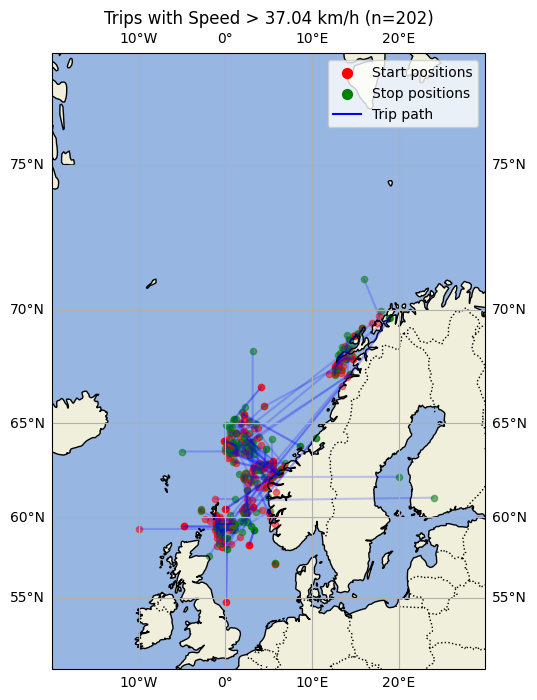

Number of trips > 37.04 km/h: 202
Average speed: 369.0 km/h
Maximum speed: 8145.3 km/h
Minimum speed: 37.1 km/h
Average distance: 179.4 km
Maximum distance: 1532.7 km
Minimum distance: 0.9 km


In [34]:
# Filter for high speeds (greater than 200 km/h)
cutoff = 20 # knop
cutoff = cutoff * 1.852 # km/h
high_speed_trips = speed_df[speed_df['avg_speed'] > cutoff].copy()

# Create a figure with Mercator projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.Mercator()})

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the start and end points and lines for each trip
for idx, row in high_speed_trips.iterrows():
	ax.scatter(row['Startposisjon lengde'], row['Startposisjon bredde'],
			  color='red', s=20, alpha=0.5, transform=ccrs.PlateCarree())
	ax.scatter(row['Stopposisjon lengde'], row['Stopposisjon bredde'],
			  color='green', s=20, alpha=0.5, transform=ccrs.PlateCarree())
	plt.plot([row['Startposisjon lengde'], row['Stopposisjon lengde']],
			 [row['Startposisjon bredde'], row['Stopposisjon bredde']],
			 color='blue', alpha=0.2, transform=ccrs.PlateCarree())

# Set extent to match the fixed bounds we used earlier
ax.set_extent(bounds_fixed, crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
ax.set_title(f'Trips with Speed > {cutoff} km/h (n={len(high_speed_trips)})')

# Add legend
ax.scatter([], [], color='red', s=50, label='Start positions')
ax.scatter([], [], color='green', s=50, label='Stop positions')
plt.plot([], [], color='blue', label='Trip path')
ax.legend()

plt.show()

# Print summary statistics
print(f"Number of trips > {cutoff} km/h: {len(high_speed_trips)}")
print(f"Average speed: {high_speed_trips['avg_speed'].mean():.1f} km/h")
print(f"Maximum speed: {high_speed_trips['avg_speed'].max():.1f} km/h")
print(f"Minimum speed: {high_speed_trips['avg_speed'].min():.1f} km/h")
print(f"Average distance: {high_speed_trips['distance'].mean():.1f} km")
print(f"Maximum distance: {high_speed_trips['distance'].max():.1f} km")
print(f"Minimum distance: {high_speed_trips['distance'].min():.1f} km")


In [ ]:
inspect_df = mac_filtered.copy()
inspect_df.drop(columns=["Hovedart FAO (kode)", "Sildebestand (kode)", "lat_distance", "lon_distance", "distance"], inplace=True)


Starttidspunkt  Startposisjon bredde  Startposisjon lengde  \
0  09.01.2011 09:30:00                58.978                -7.458   
1  09.01.2011 13:16:00                58.932                -7.460   
2  09.01.2011 15:58:00                58.943                -7.451   
3  12.01.2011 11:47:00                58.741                -7.719   
4  12.01.2011 14:53:00                58.738                -7.638   
5  12.01.2011 18:43:00                58.702                -7.770   
6  12.01.2011 20:55:00                58.689                -7.781   
7  14.01.2011 17:21:00                58.624                -7.543   
8  17.01.2011 12:20:00                58.015                -8.048   
9  17.01.2011 17:35:00                58.010                -8.055   

        Stopptidspunkt  Stopposisjon bredde  Stopposisjon lengde  Rundvekt  \
0  09.01.2011 10:29:00               58.916               -7.449  100000.0   
1  09.01.2011 13:48:00               58.960               -7.463  200000.0   
2  09.01.2011 16:11:00               58.931               -7.443  100000.0   
3  12.01.2011 12:47:00               58.758               -7.622   50000.0   
4  12.01.2011 15:55:00               58.795               -7.586   90000.0   
5  12.01.2011 19:04:00               58.715               -7.744   50000.0   
6  12.01.2011 21:26:00               58.704               -7.739  220000.0   
7  14.01.2011 17:55:00               58.624               -7.543  170000.0   
8  17.01.2011 13:30:00               58.017               -8.046  140000.0   
9  17.01.2011 17:55:00               58.008               -8.057   60000.0   

                  date  
0  2011-01-09T00:00:00  
1  2011-01-09T00:00:00  
2  2011-01-09T00:00:00  
3  2011-01-12T00:00:00  
4  2011-01-12T00:00:00  
5  2011-01-12T00:00:00  
6  2011-01-12T00:00:00  
7  2011-01-14T00:00:00  
8  2011-01-17T00:00:00  
9  2011-01-17T00:00:00

array([[<Axes: title={'center': 'Startposisjon bredde'}>,
        <Axes: title={'center': 'Startposisjon lengde'}>,
        <Axes: title={'center': 'Stopposisjon bredde'}>,
        <Axes: title={'center': 'Stopposisjon lengde'}>],
       [<Axes: title={'center': 'Rundvekt'}>,
        <Axes: title={'center': 'env_chl'}>,
        <Axes: title={'center': 'env_kd'}>,
        <Axes: title={'center': 'env_no3'}>],
       [<Axes: title={'center': 'env_nppv'}>,
        <Axes: title={'center': 'env_o2'}>,
        <Axes: title={'center': 'env_phyc'}>,
        <Axes: title={'center': 'env_po4'}>],
       [<Axes: title={'center': 'env_si'}>,
        <Axes: title={'center': 'env_zooc'}>, <Axes: >, <Axes: >]],
      dtype=object)

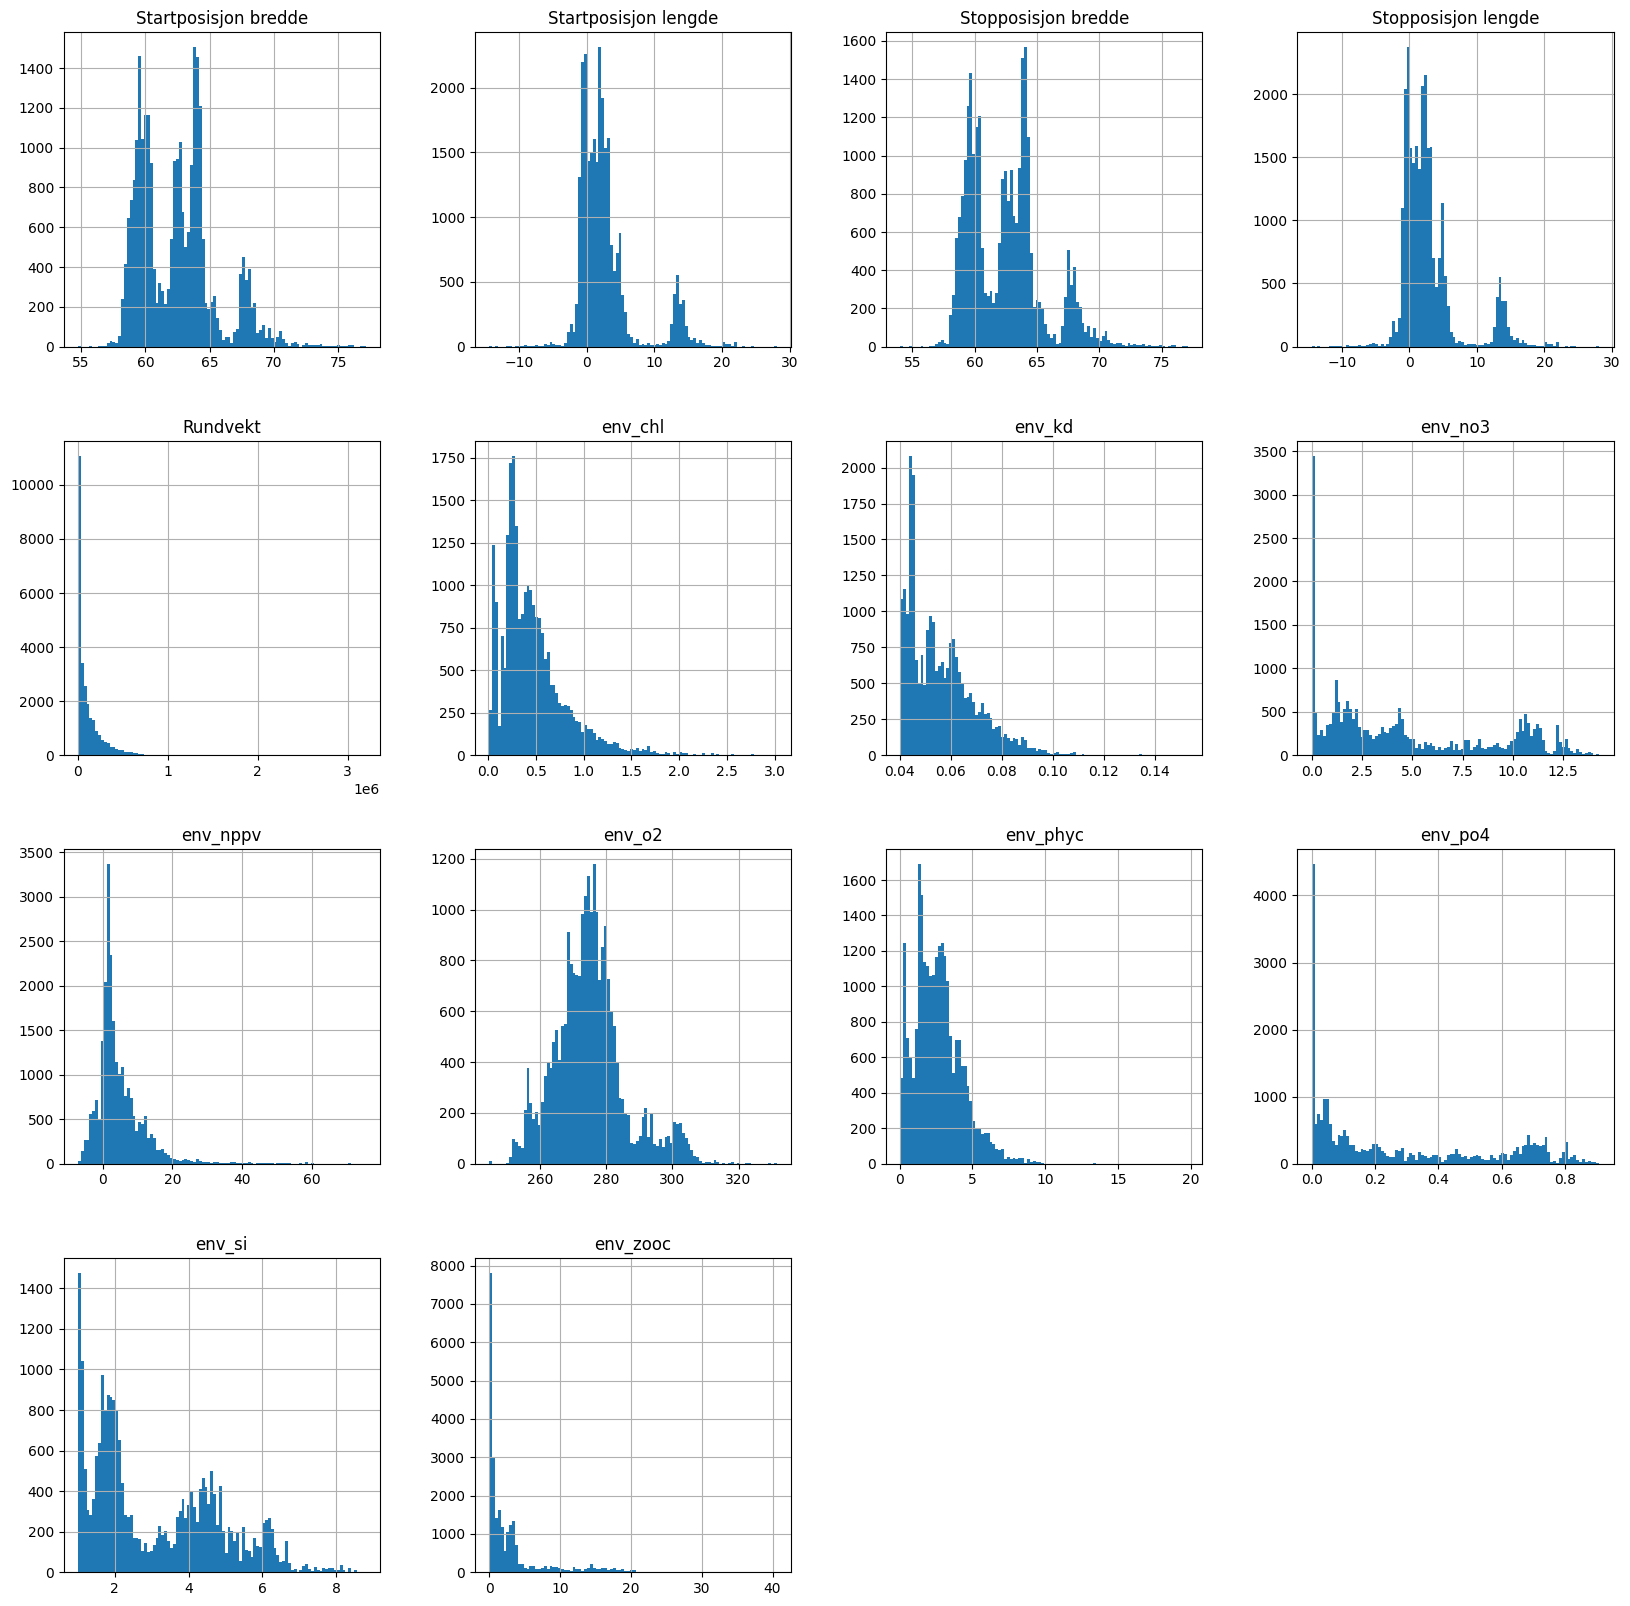

In [39]:
pd.DataFrame.hist(inspect_df, figsize=(20, 20), bins=100)

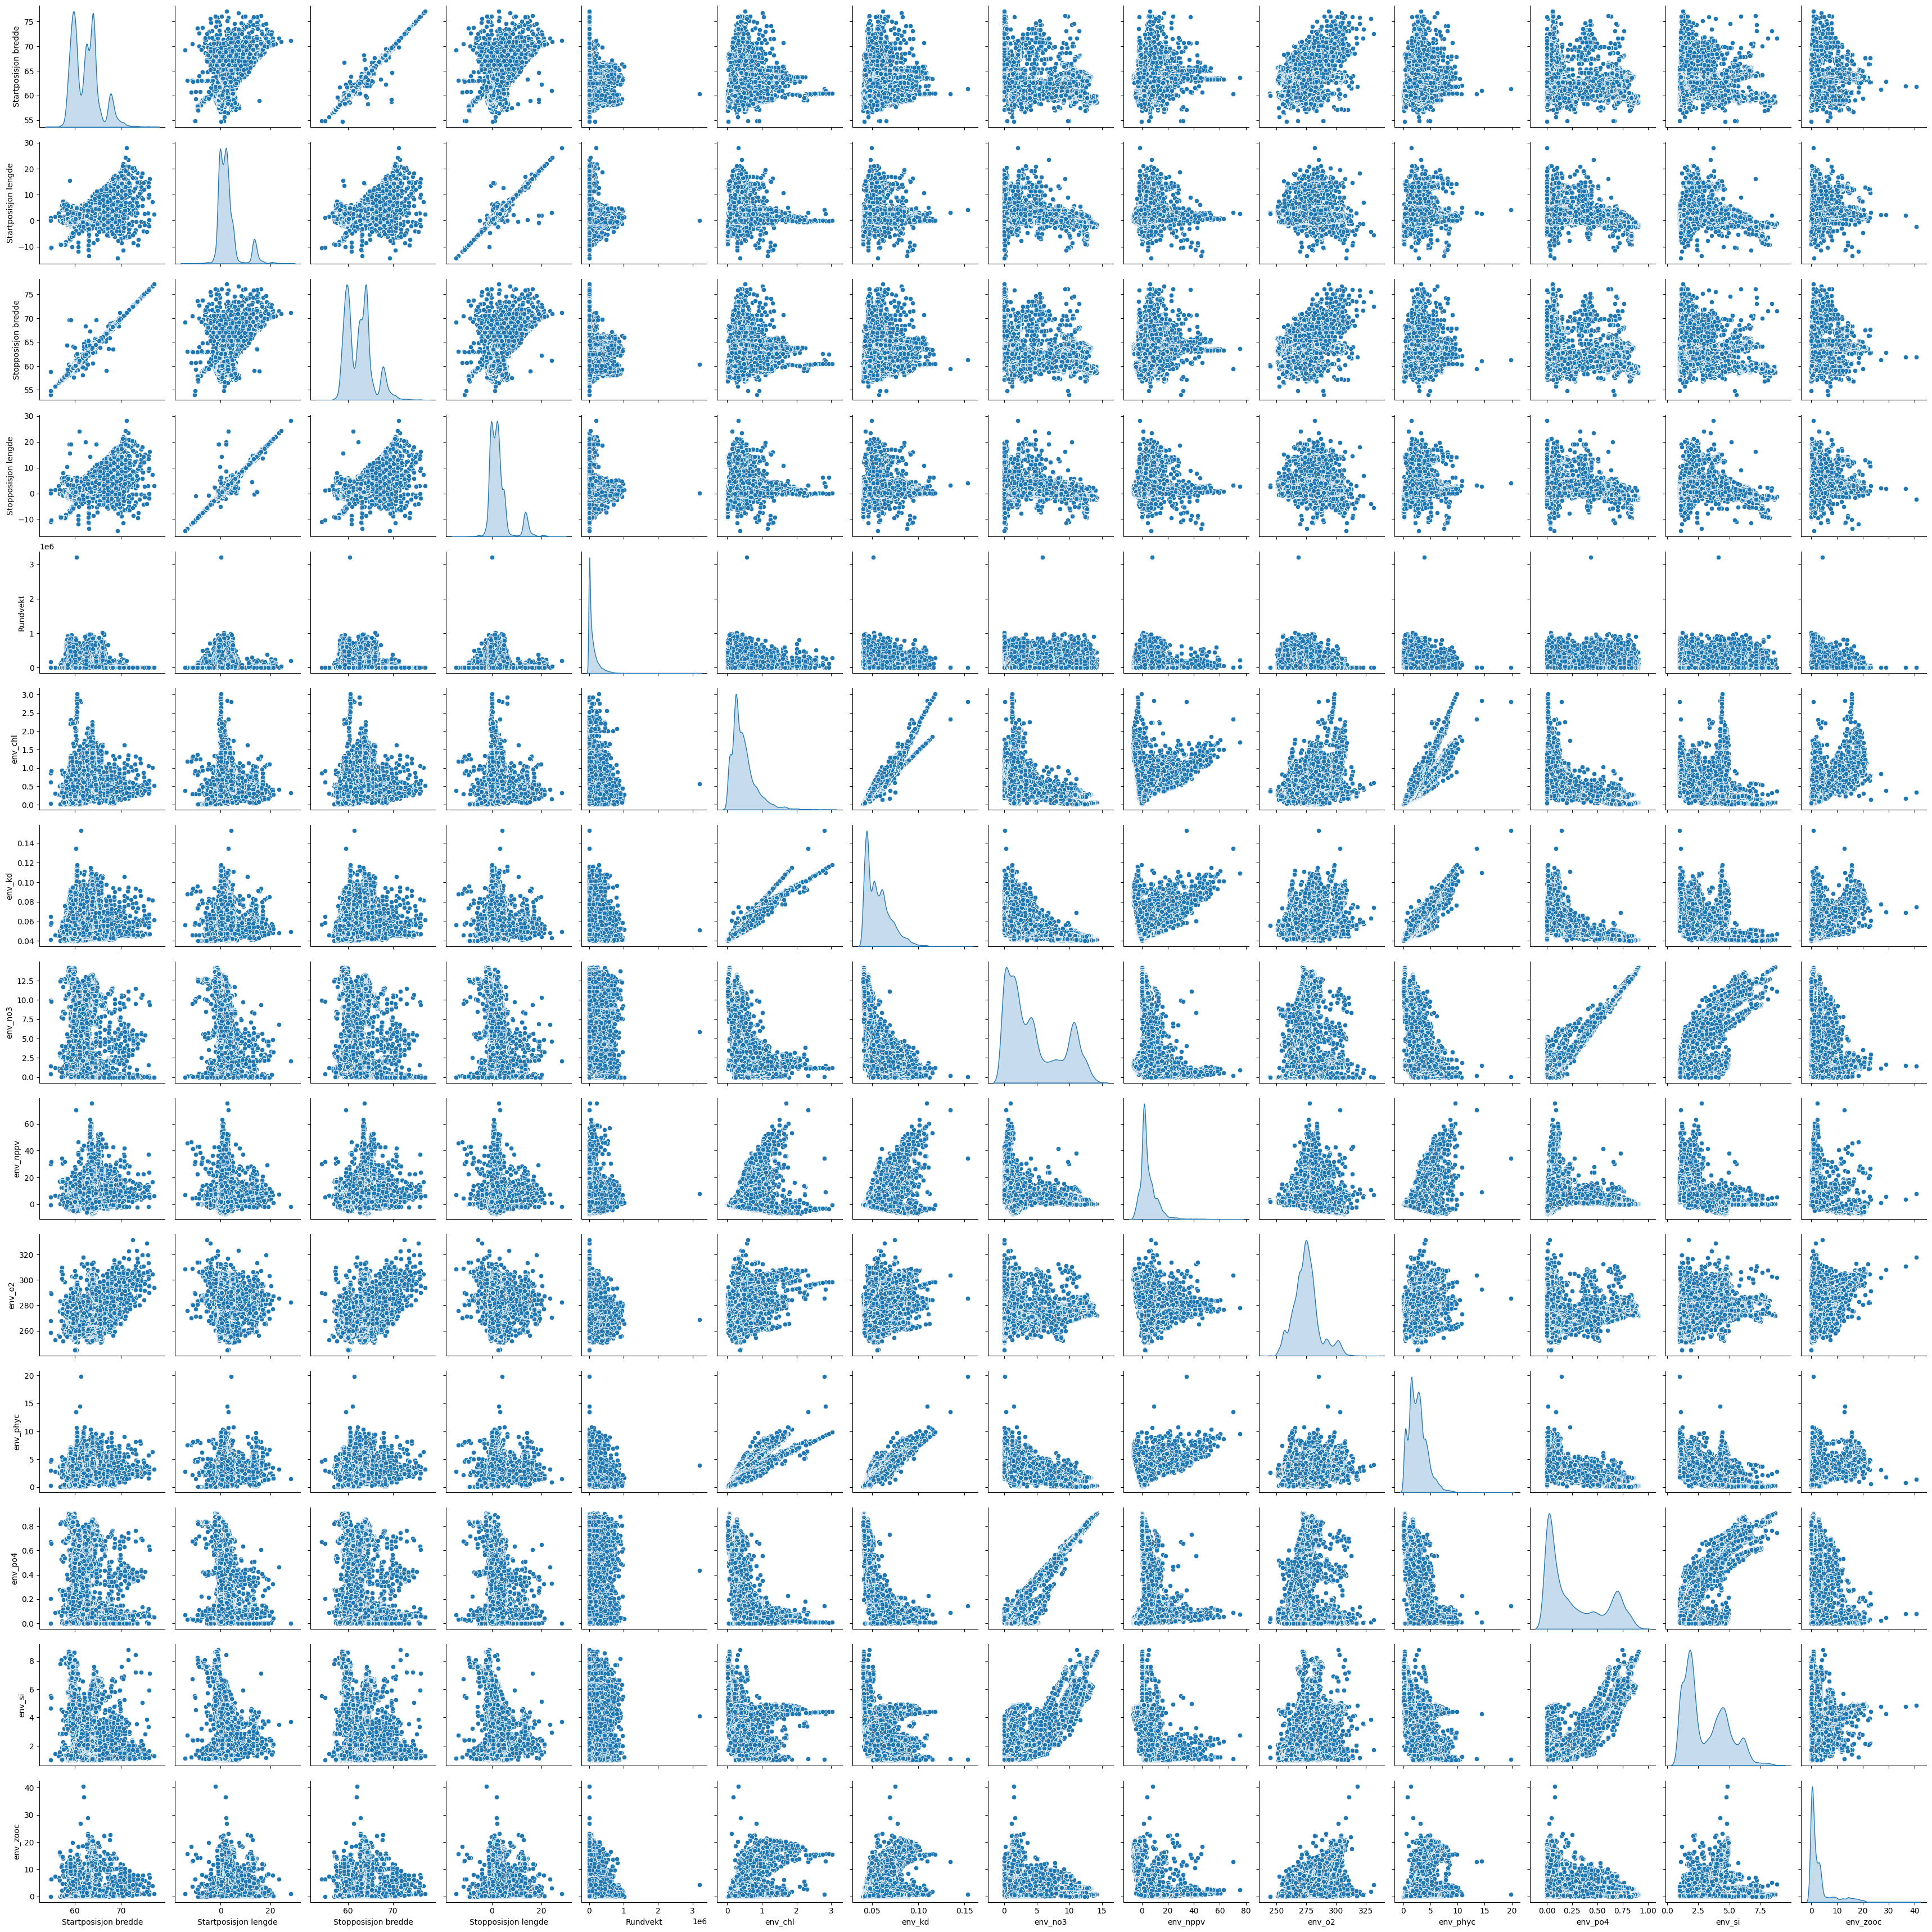

In [40]:
import seaborn as sns

sns.pairplot(inspect_df, diag_kind='kde')

<Axes: >

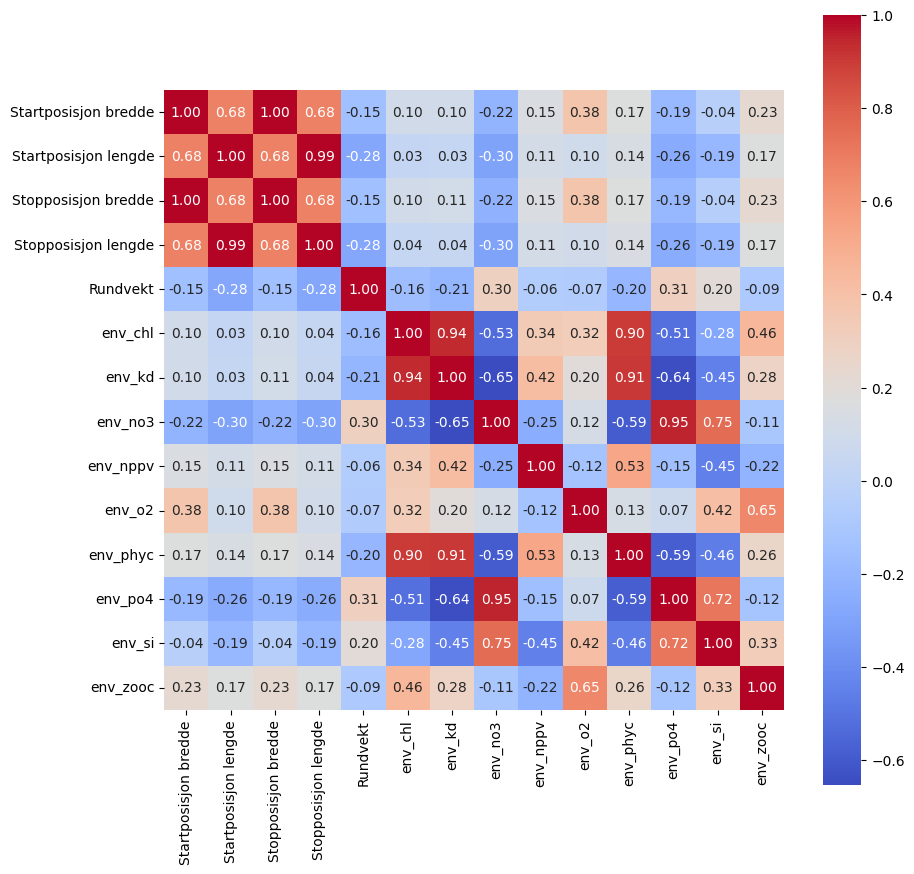

In [47]:
env_df = inspect_df.copy()
env_df.drop(columns=["Starttidspunkt", "Stopptidspunkt", "date"], inplace=True)

corr = env_df[env_df.columns].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)

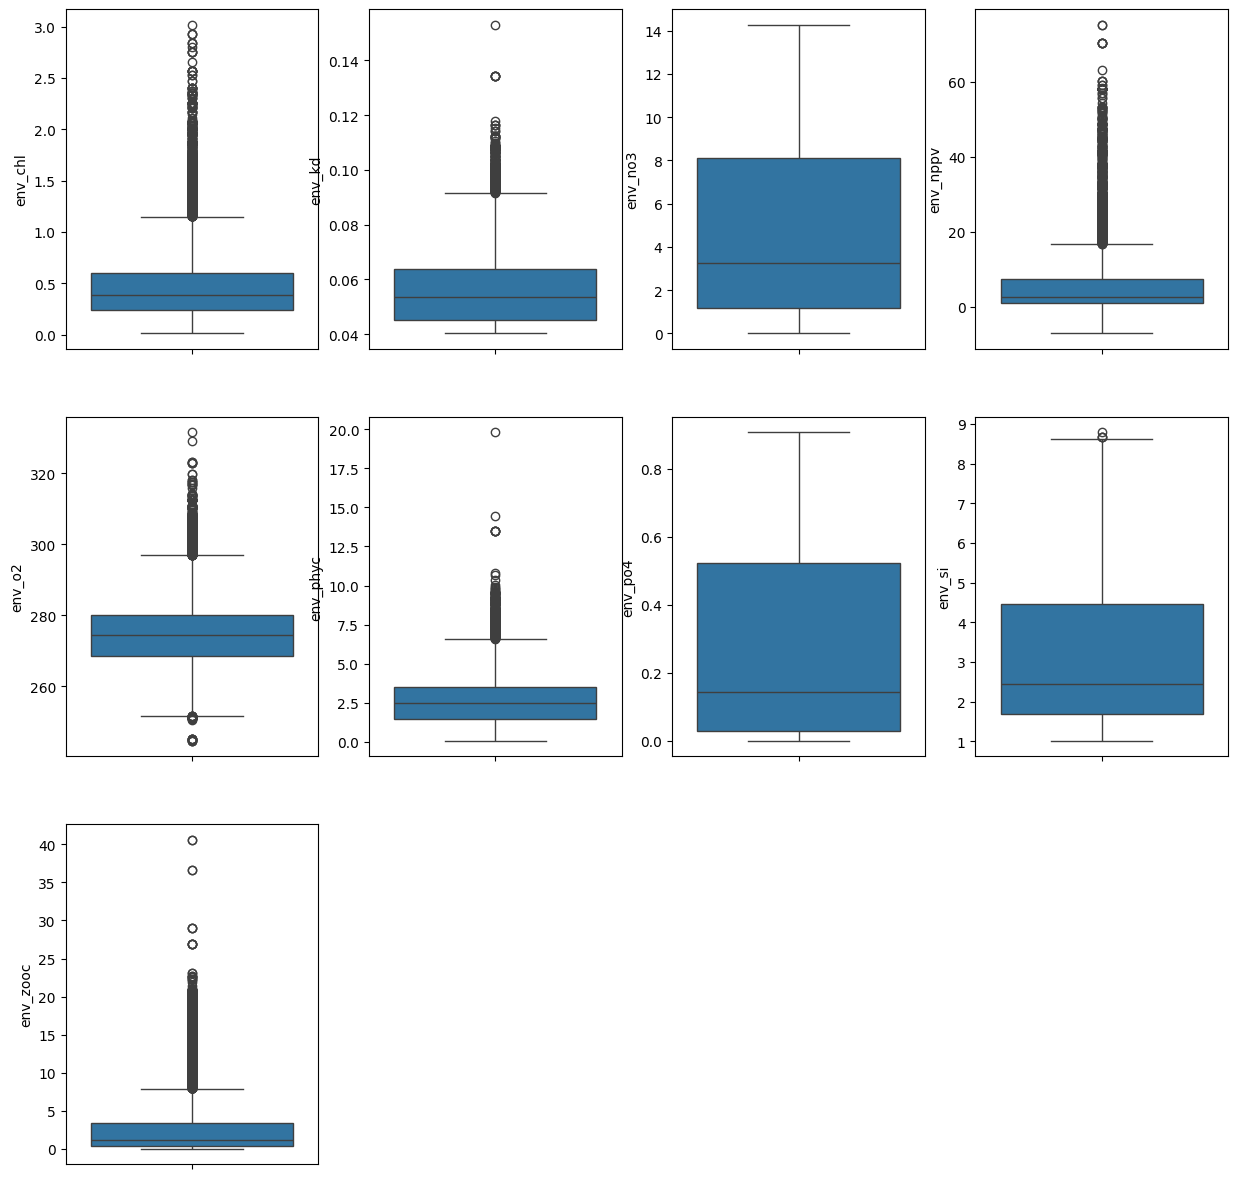

In [45]:
#--Checking Outliers
plt.figure(figsize=(15,15))
pos = 1
for i in env_df.columns:
    plt.subplot(3, 4, pos)
    sns.boxplot(data=env_df[i])
    pos += 1

In [49]:
env_df.to_csv("depth0_env_data.csv", index=False, sep=";")